# GAN実装

- https://qiita.com/triwave33/items/1890ccc71fab6cbca87e#%E3%81%AA%E3%82%93%E3%81%A8%E3%81%AA%E3%81%8F%E7%9F%A5%E3%81%A3%E3%81%A6%E3%81%84%E3%82%8B%E6%B0%97%E3%81%AB%E3%81%AA%E3%81%A3%E3%81%A6%E3%81%84%E3%82%8B%E3%81%91%E3%81%A9<br>
上記の記事を参考にGANを構築する。

### import

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

モデルの次元入力

In [3]:
img_rows = 28
img_cols = 28
channel = 1

#入力画像の次元
img_shape = (img_rows, img_cols, channel)

#生成機の入力として使われるノイズベクトルの次元
z_dim = 100


### 生成器の実装

In [9]:
def build_gengerator(img_shape, z_dim):
    
    model = Sequential()
    
    # 1層目
    #全結合層
    model.add(Dense(256, input_dim = z_dim))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    #二層目
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    # 3層目
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(BatchNormalization(momentum = 0.8))
    
    #tanhを使った出力層
    model.add(Dense(28*28*1, activation = 'tanh'))
    
    #生成機の形が画像サイズになるようにreshape
    model.add(Reshape(img_shape))
    
    return model

### 識別器

In [10]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    #入力画像を1列に（28*28）
    model.add(Flatten(input_shape = img_shape))
    
    #1層目
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.2))
    
    #2層目
    model.add(Dense(256))
    model.add(LeakyReLU(alpha = 0.2))
    
    #sigmoid関数を通して出力
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

### モデルの作成

In [11]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    #生成器と識別器の結合　
    model.add(generator)
    model.add(discriminator)
    
    return model

#識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy'
                    , optimizer = Adam()
                     , metrics = ['accuracy'])

#生成器の構築
generator = build_gengerator(img_shape, z_dim)

#生成器の構築中は識別器のパラメータを固定
discriminator.trainable = False

#生成器の訓練中のため識別器は固定しGANモデルの構築とコンパイルを行う
gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

### 訓練

In [12]:
losses = []
accuracies = []
iterati0n_checkpoint = []

def train(iterations, batch_size, sample_interval):
    
    #MNISTのデータセットのロード
    (X_train, _), (_, _) = mnist.load_data()
    
    #[0, 255]の範囲のグレースケール画素値を[-1, 1]にスケーリング
    X_train = X_train/127.5 - 1.0
    X_train = np.expand_dims(X_train, axis = 3)
    
    #本物の画像ラベルは全て1とする
    real = np.ones((batch_size, 1))
    
    #偽物のラベルは0とする
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        #--------------
        #識別器の訓練
        #--------------
        
        #本物の画像をランダムに取り出したバッチを作る
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        #偽の画像バッチを作成する
        z = np.random.randint(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        #識別器の訓練
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(imgs, fake)
        d_loss, accuracy = 0.5*np.add(d_loss_real, d_loss_fake)
        
        #--------------
        #生成期の訓練
        #--------------
        
        #偽の画像のバッチを作成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        #生成器の訓練
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration+1)%sample_interval == 0:
            
            #訓練終了後に図示するために、損失と精度をセーブしておく
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iterati0n_checkpoint.append(iteration+1)
            
            #訓練の進捗を出力
            print('%d [D loss: %f, acc.: %.2f%%] [G loss: $%f]'% (iteration+1, d_loss, 100.0*accuracy, g_loss))
            
            #生成されたサンプルを出力する
            sample_images(generator)

### 生成された画像の表示

In [13]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    
    #ランダムノイズのサンプリング
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    #ランダムノイズを使って画像を生成する
    gen_imgs = generator.predict(z)
    
    #画像の画素を[0, 1]の範囲に
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    #画像をグリッドに並べる
    fix, axs = plt.subplots(image_grid_rows
                         , image_grid_columns
                         , figsize = (4, 4)
                         , sharey = True
                         , sharex = True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            #並べた画像を出力する
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].axis('off')
            cnt += 1

### モデルの実行

1000 [D loss: 0.695882, acc.: 20.70%] [G loss: $0.001302]


KeyboardInterrupt: 

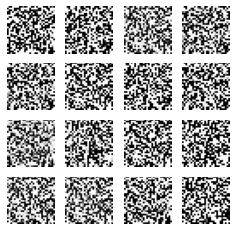

In [14]:
#ハイパーパラメータの設定
iterations = 20000
batch_size = 128
sample_interval = 1000

#設定した反復回数だけGANの訓練を行う。}
train(iterations, batch_size, sample_interval)

- Versionが古いからなんとかする。

WARNING:tensorflow:From /Users/yusuke/opt/anaconda3/envs/signate/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

In [ ]:
tensorflow --version

In [ ]:
np.random